## Spatiotemporal variation in Nitrogen Wet Deposition and Precipitation in New Hampshire

@author = Paola Miramontes
@date = 2025-10-20
@license = MIT -- https://opensource.org/licenses/MIT

## Introduction
Nitrogen (N) deposition is a key component of nutrient cycling, linking atmospheric, terrestrial, and aquatic ecosystems through the transfer of nitrogen-containing compounds. N wet deposition, the transfer of nitrogen compounds from the atmosphere to the biosphere via precipitation, plays a particularly important role because it directly affects water quality, soil biogeochemistry, and ecosystem productivity Patterns of N wet deposition are shaped by interactions between atmospheric emissions, meteorology, seasonal climate dynamics, and landscape characteristics (Murray & Wymore, 2024; Nanus et al., 2018; Wetherbee & Mast, 2016).

Historically, industrial and other anthropogenic activities increased nitrogen oxide (NOₓ) emissions, leading to elevated nitrate (NO₃⁻) wet deposition across the northeastern United States (Galloway, 2005; Houlton et al., 2013). In response to high N levels in deposition, the National Atmospheric Deposition Program (NADP) was created to monitor atmospheric deposition in the United States. Regulatory efforts from the Clean Air Act have generally been successful in decreasing deposition of oxidized forms of N (e.g. NO3-) However, in certain regions, reduced (e.g. NH4+) and organic forms have increased in recent years reflecting shifts in agricultural emissions, atmospheric chemistry, and climate-driven processes (Driscoll et al., 2024; Du, 2016; Gilliam et al., 2019; Lassiter et al., 2023; Murray et al., 2022). Dissolved organic nitrogen (DON) has not always been included in N deposition measurements but can make up a portion of total dissolved nitrogen concentrations (TDN) (Cornell, 2011; Neff et al., 2002) highlighting the importance of tracking long-term trends in both organic and inorganic (NO3-, NH4+) forms of atmospheric nitrogen.

While N deposition has been studied at regional and global scales, less focus has been on small, local scale variation. A large part of this is due to assumptions that N deposition is relatively homogeneous across short distances, however, weather patterns and geographical differences such as precipitation amount, storm trajectories, elevation, and land cover can influence both the quantity and chemical composition of N deposition. Measurements taken at one site are often used to monitor and make models that project larger scale N deposition concentrations (Ollinger et al., 1993; Schwede et al., 2018). This works for understanding national scale N deposition concentrations, yet little is known about local patterns and trends in inorganic and organic nitrogen deposition. Variation in local weather patterns and nutrient cycling may have important implications for ecosystem N loading, particularly in sensitive aquatic and forested systems. Understanding how nitrogen wet deposition varies across both time and space can help refine management strategies aimed at mitigating the harmful effects of excess or limited N deposition to terrestrial and aquatic ecosystems.

## Research question: 
Q1: How does nitrogen wet deposition (NH₄⁺, NO₃⁻, TDN, DON) vary intra-annually and interannually at two sites in New Hampshire?

Q2: Do the two New Hampshire sites differ in the magnitude or seasonal pattern of N wet deposition?

## Hypothesis: 
H1: Intra-annual variation: Different nitrogen species peak at different times of the year, with NO₃⁻ peaking in winter and NH₄⁺ and DON peaking in summer due to agricultural and natural emissions sources. Interannual variation: NO₃⁻ deposition has decreased at both sites while NH₄⁺ and DON deposition have increased, consistent with regional emission trends observed in previous studies (Murray et al, 2022).

H2: The two New Hampshire sites differ in both the magnitude and seasonal pattern of nitrogen wet deposition, with the coastal/southern site receiving consistently higher NO₃⁻ and NH₄⁺ deposition due to its proximity to urban and agricultural emission sources.

## Study site description
### Thompson Farm (TF) site:
Thompson Farm (TF) (43.11°N, 70.95°W) is a low-elevation coastal research site within the Lamprey River Hydrological Observatory in southeastern New Hampshire. The watershed is primarily forested and drains 554 km² of mixed land cover before entering the Great Bay Estuary (Wymore et al. 2021). Thompson Farm lies 23 m above sea level, ~20 km from the Atlantic Ocean, and experiences a humid temperate climate with mean annual temperature of 9.2 °C and ~127 cm of precipitation (about 2–16% as snow)(Murray et al, 2022).

Wet deposition data were collected and analyzed by the UNH Water Quality Analysis Lab (WQAL) at the University of New Hampshire. From 2003–2008, samples were obtained with an Aerochem Metrics (ACM) 301 collector in an open field, and from 2009 onward an N-CON Atmospheric Deposition Sampler mounted on a 30-m tower was used.

### Hubbard Brook (HB) site:
The Hubbard Brook Experimental Forest is located in the White Mountain National Forest in central New Hampshire with northern hardwood forests at lower elevations and spruce–fir forests at higher elevations. The climate is predominantly continental, with long, cold winters, cool summers, ~1,400 mm of annual precipitation (about one third to one quarter as snow), a persistent snowpack during the winter, and a short growing season lasting mid-May to mid-September.

At Hubbard Brook (HB), precipitation chemistry and wet deposition have been monitored since 1979 as part of the National Atmospheric Deposition Program (NADP). Wet deposition is collected using standardized NADP precipitation collectors that automatically open when precipitation occurs and close during dry periods, ensuring that only wet deposition is sampled. These collectors, located near the Forest Service headquarters in the lower valley, provide long-term, high-quality records of nitrogen, sulfur, and other ions.
 
![NH_WetDepCollectors](TF_HB_Map.jpg)
Figure 1. Map of location of wet deposition collectors in Hubbard Brook watershed and Thompson Farm (within the Lamprey River watershed). Maps modified from Wymore et al. 2021 and https://hubbardbrook.org/online-book-chapter/the-hubbard-brook-ecosystem-study-site-history-and-research-approaches/

### Data Description
The two datasets used in this study differ in their temporal coverage and sampling collection periods. Hubbard Brook wet deposition chemistry is available as weekly samples from 1978–2025 through the National Atmospheric Deposition Program (NADP). Thompson Farm wet deposition chemistry, analyzed by the New Hampshire Water Quality Analysis Lab, is available as weekly samples from 2004–2021. Although both programs report data on a weekly basis, the definition of a “week” is not fixed across sites or through time. Start and end dates of weekly collection periods differ between the two sites, can shift during the period of record, and some sample intervals extend beyond seven days due to weather, equipment issues, or operator schedules. Therefore the duration of individual sample collections varies, and weekly values represent all precipitation and associated deposition accumulated over each collection interval. To pair chemistry data with precipitation at Thompson Farm, I used daily precipitation totals from the nearby U.S. Climate Reference Network (CRN) station (Durham 2SSW), summing daily values to match each wet deposition sampling period length.

### Importing Raw Data
This script imports the raw Thompson Farm wet-deposition chemistry data, the associated QA/QC cleaning file, the daily precipitation data from the nearby CRN station, and the Hubbard Brook NADP wet-deposition dataset.

In [1]:
#%%Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from pathlib import Path
import calendar
import seaborn as sns


#%%Import data
#Import raw data

# Subdirectory to data folder
cd = Path(os.getcwd())
data = cd / 'data'

TF_file = data / '20241022_Lamprey_Precipitation.csv'
QAQC_file = data / '20211025 Lamprey Precipitation Query V4 QAQC.csv'
HB_file = data / 'NTN-nh02-w-s-mg.csv'
CRN_file = data / '20031001 to 20210422 CRN Data UNHIDs Filled.csv'

# Load data
all_dep = pd.read_csv(TF_file)
QAQC = pd.read_csv(QAQC_file)
HB = pd.read_csv(HB_file)
CRN = pd.read_csv(CRN_file, low_memory=False)

**Data Wrangling/Processing**  
This merges the Thompson Farm raw deposition data with the QA/QC file, filters the dataset to include only TF samples, and applies all QA/QC and detection-limit (DL) corrections for DOC, TDN, DON, NO₃⁻, and NH₄⁺. Each analyte is cleaned by removing flagged values, converting units where needed, and substituting half the detection limit for measurements below instrument DLs (with year-specific limits where applicable). A final dataset was produced that includes site metadata and DL-corrected solute concentrations, excluding samples without chemistry measurements.

In [2]:
#%%Merge TF df to clean
#Rename the QAQC column to match all_dep
QAQC = QAQC.rename(columns={"UNHID#": "UNH ID #"})

#Merge on 'UNH ID #' using a left join (keep all raw data rows)
merged_dep = pd.merge(all_dep, QAQC, on="UNH ID #", how="left")

#%%Subset df
# Make sure Year is numeric
merged_dep["Year"] = pd.to_numeric(merged_dep["Year"])

#Subset: data only for TF
TF_dep = merged_dep[merged_dep["Sample Name"] == "TF2"].copy()

#%%Clean data

######Clean data: Fields for DOC, TDN, DON, NO3, NH4

#For each variable 1) filter for data flags (keep only 0, 2), clean for 1/2 DL
#TDN (mg N/L) DL limits 2002 - 2014 = 0.07, 2014-present = 0.05
TF_dep["TDNf"] = pd.to_numeric(TF_dep["TDNf"], errors="coerce")
TF_dep["TDN_clean"] = np.where(TF_dep["TDNf"] <= 2, TF_dep["TDN (mg N/L)"], np.nan)
TF_dep["TDN_dl_corr_mgNL"] = np.where(
    ((TF_dep["Year"] < 2014) & (TF_dep["TDN_clean"] <= 0.07)), 0.035,
    np.where(((TF_dep["Year"] >= 2014) & (TF_dep["TDN_clean"] <= 0.05)), 0.025, TF_dep["TDN_clean"]))

##DON (mgN/L and calculated by subtraction) DL = 0.01 (not year dependent because calculated)
TF_dep["DONf"] = pd.to_numeric(TF_dep["DONf"], errors="coerce")
TF_dep["DON_clean"] = np.where(TF_dep["DONf"] <= 2, TF_dep["DON"], np.nan)
TF_dep["DON_dl_corr_mgNL"] = np.where(TF_dep["DON_clean"] <= 0.01, 0.005, TF_dep["DON_clean"])

#NO3 (mgN/L) DL limits 2002 - 2006 = 0.005, 2006-present = 0.004
TF_dep["NO3_Combf"] = pd.to_numeric(TF_dep["NO3_Combf"], errors="coerce")
TF_dep["NO3_clean"] = np.where(TF_dep["NO3_Combf"] <= 2, TF_dep["NO3_Final"], np.nan)
TF_dep["NO3_dl_corr_mgNL"] = np.where(
    ((TF_dep["Year"] < 2006) & (TF_dep["NO3_clean"] <= 0.005)), 0.0025,
    np.where(((TF_dep["Year"] >= 2006) & (TF_dep["NO3_clean"] <= 0.004)), 0.002, TF_dep["NO3_clean"]))

#NH4 (mgN/L) DL = 0.004 (or 4ug/L)
TF_dep["NH4_Combf"] = pd.to_numeric(TF_dep["NH4_Combf"], errors="coerce")
TF_dep["NH4_clean"] = np.where(TF_dep["NH4_Combf"] <= 2, TF_dep["NH4 (ug N/L)"], np.nan)
TF_dep["NH4_mgL_clean"] = TF_dep["NH4_clean"] / 1000
TF_dep["NH4_dl_corr_mgNL"] = np.where(TF_dep["NH4_mgL_clean"] <= 0.004, 0.002, TF_dep["NH4_mgL_clean"])

#%%New df for clean precip data for TF (DL corrected and QA/QC)

#Select columns to include in final df
final_cols = [
    # Site / sample information
    'UNH ID #', 
    'Sample Name', 
    'Collection Date', 
    'Collection Time', 
    'Project_x', 
    'Sub_Project_x', 
    'Year',
    # DL-corrected values
    'TDN_dl_corr_mgNL', 
    'DON_dl_corr_mgNL', 
    'NO3_dl_corr_mgNL', 
    'NH4_dl_corr_mgNL'
]

# Subset df
TF_sub = TF_dep[final_cols].copy()

#Drop rows with missing data for solutes
solutes = [
 'TDN_dl_corr_mgNL',
 'DON_dl_corr_mgNL',
 'NO3_dl_corr_mgNL',
 'NH4_dl_corr_mgNL']

TF_sub = TF_sub.dropna(subset=solutes, how="all").copy()

This section processes CRN precipitation data to match the Thompson Farm sampling intervals. Collection start and end times are created for each TF sample, CRN timestamps are converted to datetime, and each CRN precipitation record is assigned to the correct sampling interval. Precipitation is then summed for each interval and merged with the TF chemistry dataset to produce a final, TF dataset precipitation.

In [3]:
#%% Wrangling CRN precip data for TF
# Combine date + time and convert to datetime
TF_sub['DateTime_end'] = pd.to_datetime(
    TF_sub['Collection Date'] + ' ' + TF_sub['Collection Time'],
    format="%d-%b-%y %I:%M:%S %p",
    errors='coerce'
)

#Create DateTime_begin as previous row's DateTime_end
TF_sub['DateTime_begin'] = TF_sub['DateTime_end'].shift(1)

#Add Month and Sampling Interval
TF_sub['Month'] = TF_sub['DateTime_begin'].dt.month.fillna(TF_sub['DateTime_end'].dt.month)
TF_sub['Sampling.Interval'] = range(1, len(TF_sub)+1)

#Convert CRN hourly data to datetime
CRN['Date_new'] = pd.to_datetime(CRN['Date_Hour_end_EST'].str.strip(), format="%m/%d/%y %H:%M", errors='coerce')

#Assign each CRN record to the correct sampling interval
CRN['Sampling.Interval'] = np.nan
for idx, row in TF_sub.iloc[1:].iterrows():  # skip first row
    mask = (CRN['Date_new'] > row['DateTime_begin']) & (CRN['Date_new'] <= row['DateTime_end'])
    CRN.loc[mask, 'Sampling.Interval'] = row['Sampling.Interval']

#Sort CRN by datetime
CRN = CRN.sort_values('Date_new')

#Sum precipitation by sampling interval
CRN_sum = (
    CRN.groupby("Sampling.Interval", dropna=False)
    .agg(precip_mm=("TF_P_wUNHfilled_mm", "sum"))
    .reset_index()
)

#Merge summed CRN precipitation with TF_sub
TF_final = pd.merge(TF_sub, CRN_sum, on="Sampling.Interval", how="left")

#Change end date column to datetime
TF_final['enddate'] = pd.to_datetime(TF_final['DateTime_end'])

This function processes raw Hubbard Brook wet deposition data from the NADP by converting NH₄⁺ and NO₃⁻ to mg N/L, filtering for valid samples, standardizing date columns, and returning a cleaned dataset with only relevant columns.”

In [4]:
def clean_NADP(HB_raw):
    """
    Cleans Hubbard Brook wet deposition data:
    - Converts NO3 and NH4 to mg N/L
    - Filters rows based on valid valcodes
    - Converts dates to datetime
    - Returns a cleaned, subset DataFrame
    """

    HB = HB_raw.copy()

    # Convert NH4 and NO3 to mg N/L
    Nu = 14.007 * 1000      # mg/mol N
    NH4u = 18.04 * 1000     # mg/mol NH4
    NO3u = 62.0049 * 1000   # mg/mol NO3

    HB['NH4mgNL'] = HB['NH4'] * (Nu / NH4u)
    HB['NO3mgNL'] = HB['NO3'] * (Nu / NO3u)

    # Filter for valid value codes
    valid_codes = ["w ", "wa", "wi", "wd"]
    HB_clean = HB[HB["valcode"].isin(valid_codes)].copy()

    # Process date columns
    HB_clean['enddate'] = pd.to_datetime(HB_clean['dateOff'])

    # Keep only relevant columns
    final_cols = [
        'siteID', 'labno', 'dateOn', 'dateOff', 'enddate',
        'yrmonth', 'flagNa', 'flagNH4', 'NH4mgNL',
        'flagNO3', 'NO3mgNL', 'subppt'
    ]

    HB_final = HB_clean[final_cols].copy()
    return HB_final

HB_final = clean_NADP(HB)

**Weekly precipitation time series for TF and HB sites**  
This plot shows weekly precipitation at the TF and HB sites over the entire study period to visualize differences in precipitation events between sites and to identify periods where sample collection overlaps.

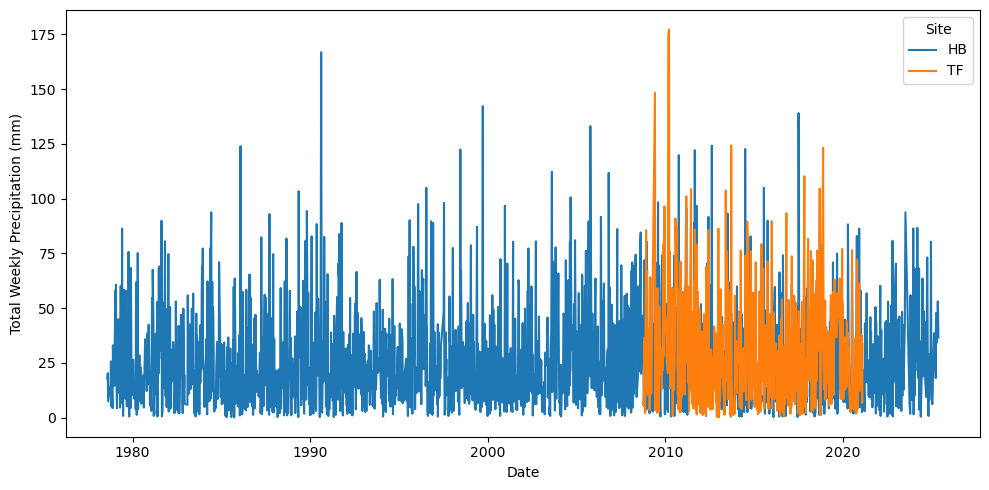

In [5]:
#%%Timeseries Plot for TF and HB weekly precipitation
fig, ax = plt.subplots(figsize=(10, 5))

# Create a list of dataframes and their site labels
sites = [
   ("HB", HB_final, "subppt") ,   #HB precipitation column
   ("TF", TF_final, "precip_mm")  #TF precipitation column
]

for site_name, df, precip_col in sites:
    # Make sure the dataframe has non-null dates
    df_plot = df.dropna(subset=['enddate', precip_col])
    ax.plot(df_plot['enddate'], df_plot[precip_col], label=site_name)

ax.set(
    xlabel='Date',
    ylabel='Total Weekly Precipitation (mm)'
)
ax.legend(title='Site')
plt.tight_layout()
plt.show()

This combines site datasets for overlapping analysis. Subsets of the TF and HB data are created with standardized column names and added site and wateryear information. The HB data are filtered to match the date range of TF data, and then both datasets are concatenated for combined analysis of weekly precipitation and nutrient measurements

In [6]:
#%% Create new TF and HB subsets with renamed columns + wateryear for concatentation
#===========TF===============
#TF subset
TF_renamed = TF_final.rename(columns={
    'DateTime_begin': 'startdate',
    'TDN_dl_corr_mgNL': 'TDNmgNL',
    'DON_dl_corr_mgNL': 'DONmgNL',
    'NH4_dl_corr_mgNL': 'NH4mgNL',
    'NO3_dl_corr_mgNL': 'NO3mgNL'
})

# Add site
TF_renamed['site'] = "TF"

# Select columns
TF_sub2 = TF_renamed[[
    'site',
    'startdate',
    'enddate',
    'precip_mm',
    'TDNmgNL',
    'DONmgNL',
    'NO3mgNL',
    'NH4mgNL'
]].copy()

# Water year
TF_sub2['wateryear'] = np.where(
    TF_sub2['enddate'].dt.month >= 10,
    TF_sub2['enddate'].dt.year + 1,
    TF_sub2['enddate'].dt.year
)

#===========HB===============
#HB subset
HB_renamed = HB_final.rename(columns={
    'subppt': 'precip_mm'
})

# Add site
HB_renamed['site'] = 'HB'

# Convert startdate
HB_renamed['startdate'] = pd.to_datetime(HB_renamed['dateOn'], errors='coerce')

# Ensure enddate is datetime
HB_renamed['enddate'] = pd.to_datetime(HB_renamed['enddate'], errors='coerce')

# Select only columns you want
HB_sub2 = HB_renamed[[
    'site',
    'startdate',
    'enddate',
    'yrmonth',
    'precip_mm',
    'NH4mgNL',
    'NO3mgNL'
    
]].copy()

# Add wateryear
HB_sub2['wateryear'] = np.where(
    HB_sub2['enddate'].dt.month >= 10,
    HB_sub2['enddate'].dt.year + 1,
    HB_sub2['enddate'].dt.year
)

# Get min and max dates from TF data
tf_start = TF_sub2['enddate'].min()
tf_end = TF_sub2['enddate'].max()

# Keep only HB rows within TF date range
HB_sub2 = HB_sub2[(HB_sub2['enddate'] >= tf_start) & (HB_sub2['enddate'] <= tf_end)].copy()


#Combine TF and HB
combined = pd.concat([TF_sub2, HB_sub2], ignore_index=True).sort_values(['site','startdate'])

**Calculations: Volume Weighted Mean (VWM) concentrations and loads**

For each solute, concentrations are weighted by the precipitation on the days they were measured to compute volume-weighted mean (VWM) concentrations. VWM concentrations account for differences in precipitation between sampling periods, giving a fair estimate of the average solute concentration in precipitation over a month. These VWM values are then used to calculate daily wet deposition fluxes (loads) in mg/m²/day and converted to kg/ha/day for each site and month.

In [7]:
#%%Precipitation-weighted concentrations
#Calculate Precipitation-Weighted Concentrations for each solute by first multiplying each measured concentration by the rainfall for that ~weekly time period
#Create a second column for rainfall totals on days a solute was measured - accounts for weeks where there wasn't enough sample to run all of the analyses 

#Explanation:
#NO3mgNL_mm (concentration × precip)
#NO3_mm (precip only when NO3 was measured)
#VWM:annual['NO3_mgL_vwm'] = annual['NO3mgNL_mm']/annual['NO3_mm']

#Average monthly concentrations weighted by precipitation
combined['yrmonth'] = (
    combined['enddate'].dt.year * 100 +
    combined['enddate'].dt.month
)

#Compute solute × precipitation (mg/L × mm) (precipitation-weighted mass columns) (numerator)
combined['TDNmgNL_mm']  = (combined['TDNmgNL']  * combined['precip_mm']).where(combined['TDNmgNL'].notna())
combined['NO3mgNL_mm']  = (combined['NO3mgNL']  * combined['precip_mm']).where(combined['NO3mgNL'].notna())
combined['NH4mgNL_mm']  = (combined['NH4mgNL']  * combined['precip_mm']).where(combined['NH4mgNL'].notna())
combined['DONmgNL_mm']  = (combined['DONmgNL']  * combined['precip_mm']).where(combined['DONmgNL'].notna())


#Precip for each solute (denominator) only where solute is measured
#Prevents accidentally including precipitation from rows where the solute is missing
combined['TDN_mm']  = combined['precip_mm'].where(combined['TDNmgNL'].notna())
combined['NO3_mm']  = combined['precip_mm'].where(combined['NO3mgNL'].notna())
combined['NH4_mm']  = combined['precip_mm'].where(combined['NH4mgNL'].notna())
combined['DON_mm']  = combined['precip_mm'].where(combined['DONmgNL'].notna())

#Group by site and month, sum numerator & denominator
monthly_weighted = combined.groupby(['site','yrmonth']).agg({
    'TDNmgNL_mm':'sum',
    'NO3mgNL_mm':'sum',
    'NH4mgNL_mm':'sum',
    'DONmgNL_mm':'sum',
    'TDN_mm':'sum',
    'NO3_mm':'sum',
    'NH4_mm':'sum',
    'DON_mm':'sum',
    'precip_mm':'sum'  # total precipitation
}).reset_index()

#Calculate Volume-Weighted Mean Concentrations (mg/L)
monthly_weighted['TDN_mgL_vwm']  = monthly_weighted['TDNmgNL_mm'] / monthly_weighted['TDN_mm']
monthly_weighted['NO3_mgL_vwm']  = monthly_weighted['NO3mgNL_mm'] / monthly_weighted['NO3_mm']
monthly_weighted['NH4_mgL_vwm']  = monthly_weighted['NH4mgNL_mm'] / monthly_weighted['NH4_mm']
monthly_weighted['DON_mgL_vwm']  = monthly_weighted['DONmgNL_mm'] / monthly_weighted['DON_mm']

#%%#%%Caluclate wet deposition load (kgN/ha/d)
#Explanation:numerator Σ(conc × precip) is already mg/m²
#convert mg/m²/year → kg/ha/year (× 0.01)

# Extract year and month
monthly_weighted['year'] = monthly_weighted['yrmonth'] // 100
monthly_weighted['month'] = monthly_weighted['yrmonth'] % 100

# Days in month
monthly_weighted['days_in_month'] = monthly_weighted.apply(
    lambda row: calendar.monthrange(row['year'], row['month'])[1],
    axis=1
)
# # Convert yrmonth to a datetime (use first day of the month)
monthly_weighted['date'] = pd.to_datetime(
    monthly_weighted['yrmonth'].astype(str), format='%Y%m'
)

# Solutes list
solutes = ['NO3', 'NH4', 'DON', 'TDN']

# Calculate daily wet deposition load (mg/m²/day)
for s in solutes:
    vwm_col = f'{s}_mgL_vwm'  # numerator: VWM concentration
    mm_col  = f'{s}_mm'       # denominator: total precipitation contributing to VWM
    load_col = f'{s}_load_mg_m2_d'
    
    #only compute if both columns exist and not NaN
    monthly_weighted[load_col] = (
        monthly_weighted[vwm_col] * monthly_weighted[mm_col]
    ) / monthly_weighted['days_in_month']
    
#convert mg/m²/day → kg/ha/day
for s in solutes:
    monthly_weighted[f'{s}_load_kg_ha_d'] = monthly_weighted[f'{s}_load_mg_m2_d'] * 0.01

This calculates **annual** VWM concentrations and loads for each site

In [8]:
#%%Water-Year Annual VWM and Loads
#Group by site, water year and sum weekly values
annual = (
    combined
    .groupby(['site','wateryear'])
    .agg({
        'precip_mm':'sum',            # total precip for the WY

        # numerators: Σ (conc × precip)
        'NO3mgNL_mm':'sum',
        'NH4mgNL_mm':'sum',
        'DONmgNL_mm':'sum',
        'TDNmgNL_mm':'sum',

        # denominators: Σ precip where solute was measured
        'NO3_mm':'sum',
        'NH4_mm':'sum',
        'DON_mm':'sum',
        'TDN_mm':'sum'
    })
    .reset_index()
)

#Calculate water-year VWM concentrations (mg/L)
annual['NO3_mgL_vwm'] = annual['NO3mgNL_mm'] / annual['NO3_mm']
annual['NH4_mgL_vwm'] = annual['NH4mgNL_mm'] / annual['NH4_mm']
annual['DON_mgL_vwm'] = annual['DONmgNL_mm'] / annual['DON_mm']
annual['TDN_mgL_vwm'] = annual['TDNmgNL_mm'] / annual['TDN_mm']


#Calculate annual wet deposition loads
#Explanation:numerator Σ(conc × precip) is already mg/m²
#convert mg/m²/year → kg/ha/year (× 0.01)


for s in solutes:
    num_col = f'{s}mgNL_mm'  # numerator column for annual load
    load_col_mg = f'{s}_annual_load_mg_m2_y'
    load_col_kg = f'{s}_annual_load_kg_ha_y'

    annual[load_col_mg] = annual[num_col]              # already mg/m²
    annual[load_col_kg] = annual[num_col] * 0.01       # mg/m² → kg/ha

## Results

**Time Series Plot**

This plot shows the monthly volume-weighted mean (VWM) concentrations of ammonium (NH₄) and nitrate (NO₃) for each site along with monthly total precipitation as bars for the overlapping years of N deposition collection.

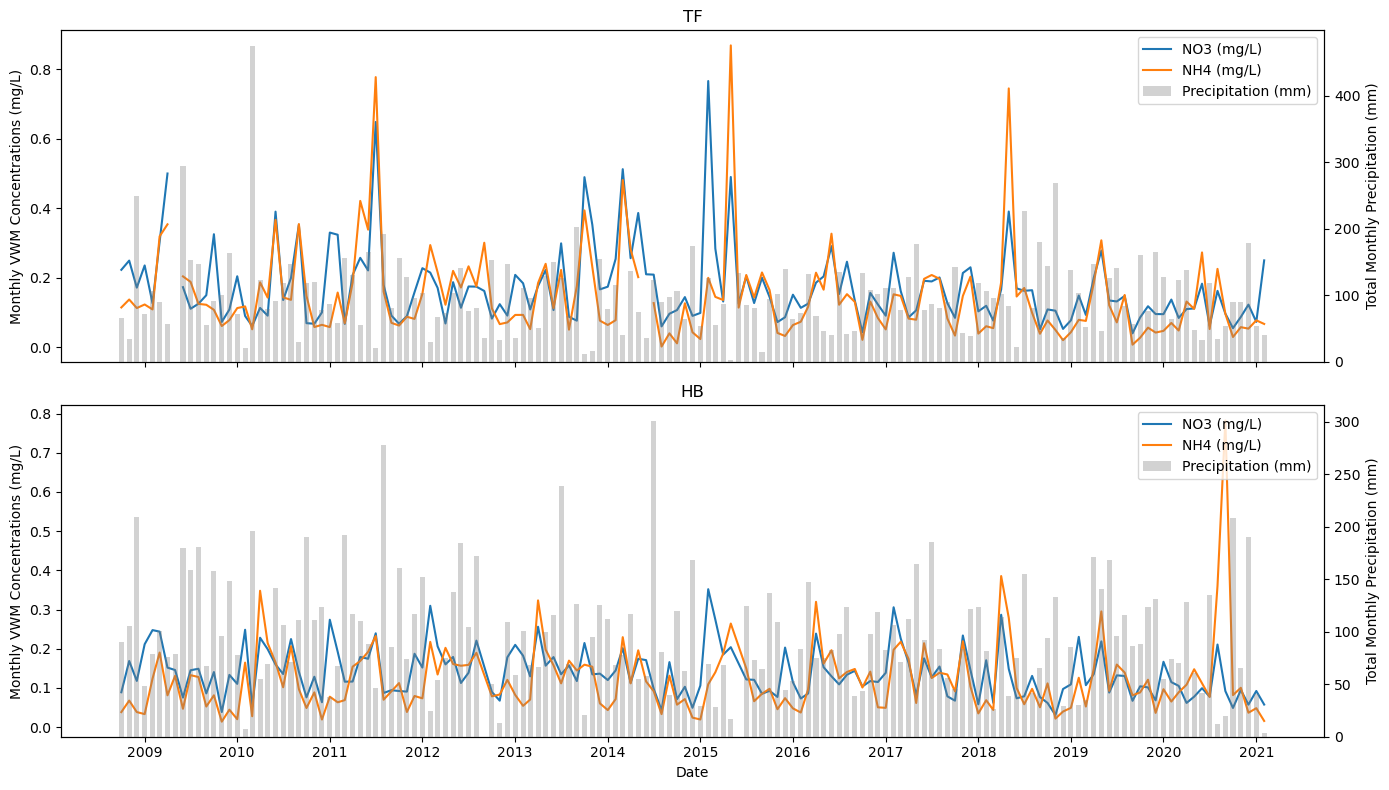

In [9]:
#%% Plot of NH4 and NO3 chemistry with precipitation per site

import matplotlib.dates as mdates

#solutes to plot
solutes_to_plot = ['NO3_mgL_vwm', 'NH4_mgL_vwm']

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
sites_order = ['TF', 'HB']

for ax, site in zip(axes, sites_order):

    df = monthly_weighted[monthly_weighted['site'] == site].copy()

    ax.set_title(f"{site}") 
    
    # Create twin axis for precipitation
    ax2 = ax.twinx()

    #LEFT AXIS: chemistry 
    for s in solutes_to_plot:
        ax.plot(df['date'], df[s],
                label=s.replace('_mgL_vwm', ' (mg/L)'))

    ax.set_ylabel("Monthly VWM Concentrations (mg/L)")

    #RIGHT AXIS: precipitation bars
    ax2.bar(df['date'], df['precip_mm'],
            width=20, alpha=0.35, color='gray',
            label="Precipitation (mm)")

    ax2.set_ylabel("Total Monthly Precipitation (mm)")

    # Combined legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2,
              loc='upper right')

# Shared x-axis formatting
axes[-1].set_xlabel("Date")
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

**Figure 1.** Monthly volume-weighted mean (VWM) concentrations of NH₄ and NO₃ (mg/L) and total monthly precipitation (mm) at the TF and HB sites.

NH₄ and NO₃ concentrations tend to be higher during months with lower precipitation, indicating that the solute input per unit of precipitation was higher during these periods. Concentration peaks for both NH₄ and NO₃ were variable over time, reflecting temporal variability in atmospheric deposition.

**Examining Interannual Variability**

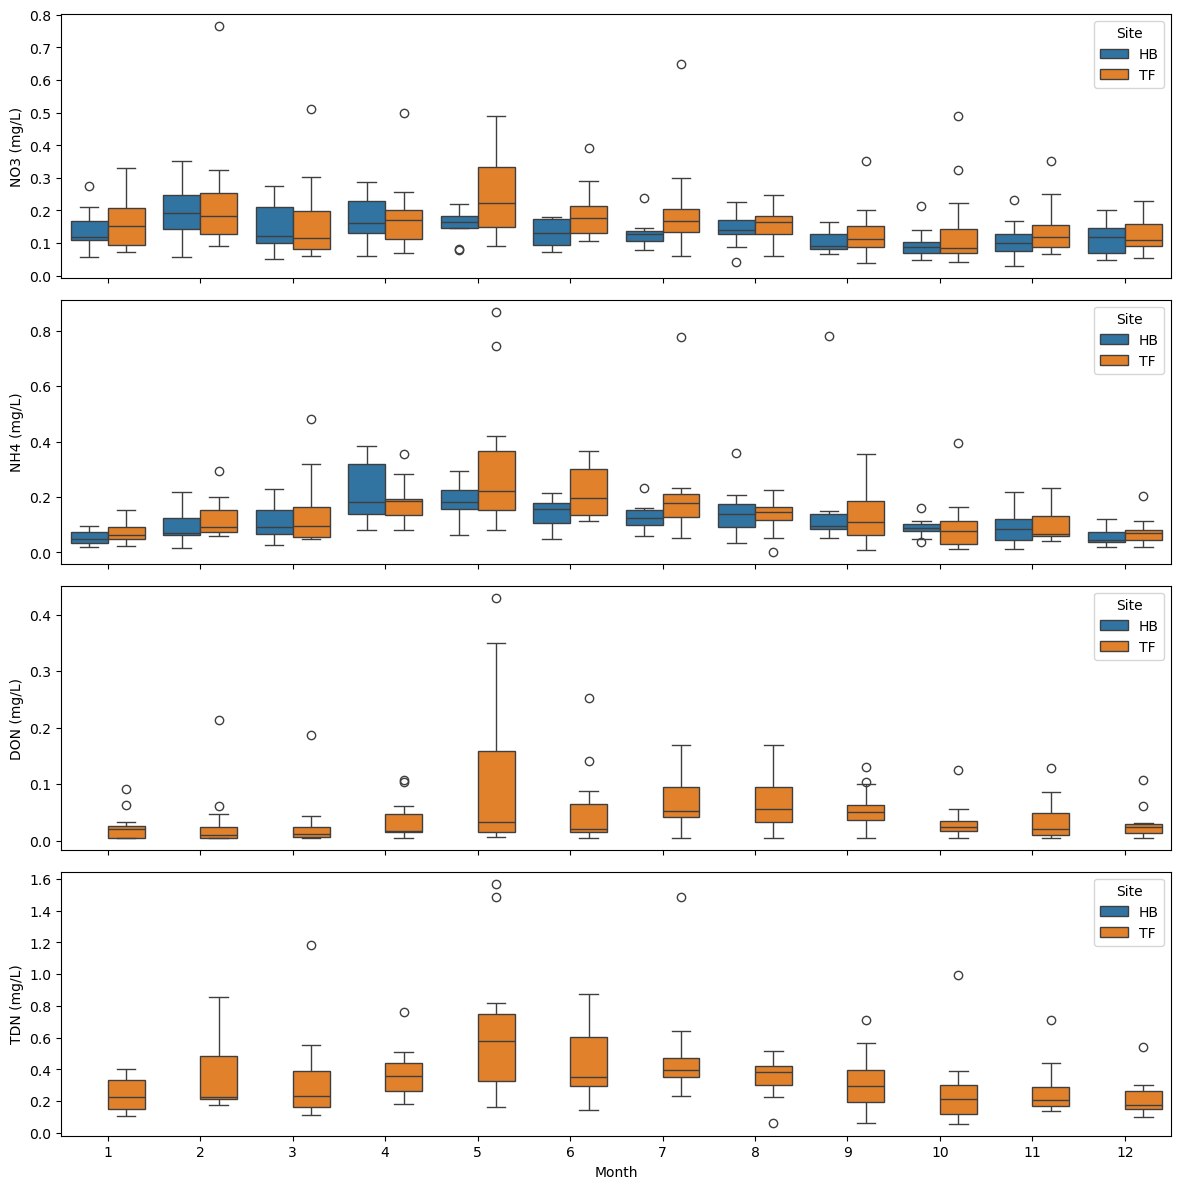

In [10]:
#%%Intrannual varability boxplots for VWM conc

fig, axes = plt.subplots(len(solutes), 1, figsize=(12, 3*len(solutes)), sharex=True)

for ax, s in zip(axes, solutes):
    vwm_col = f"{s}_mgL_vwm"
    
    sns.boxplot(
        data=monthly_weighted,
        x="month",
        y=vwm_col,
        hue="site",
        ax=ax
    )

    ax.set_ylabel(f"{s} (mg/L)")
    ax.legend(title="Site")

axes[-1].set_xlabel("Month")
plt.tight_layout()
plt.show()


**Figure 3.** Monthly Volume Weighted Mean (VWM) concentrations for NH4, NO3, DON, and TDN from 2009-2021. 

Only NH₄ and NO₃ are measured at HB, whereas all solutes are measured at TF. The inorganic nitrogen species (NH₄ and NO₃) show different temporal patterns between sites. At TF, nitrate concentrations peak in May, while at HB, the highest nitrate values occur earlier, in February–March. Ammonium concentrations are elevated at both sites during the spring months (April–June). Nitrate and ammonium concentrations tend to be higher at HB, though differences are may not be statistically significant (still working on the stats). Dissolved organic nitrogen also tends to increase in the summer months with high variability in May but has overall low concentrations. TDN (NH4+NO3+DON) is highest during spring months which could be driven by inorganic N species (perticularly NH4).

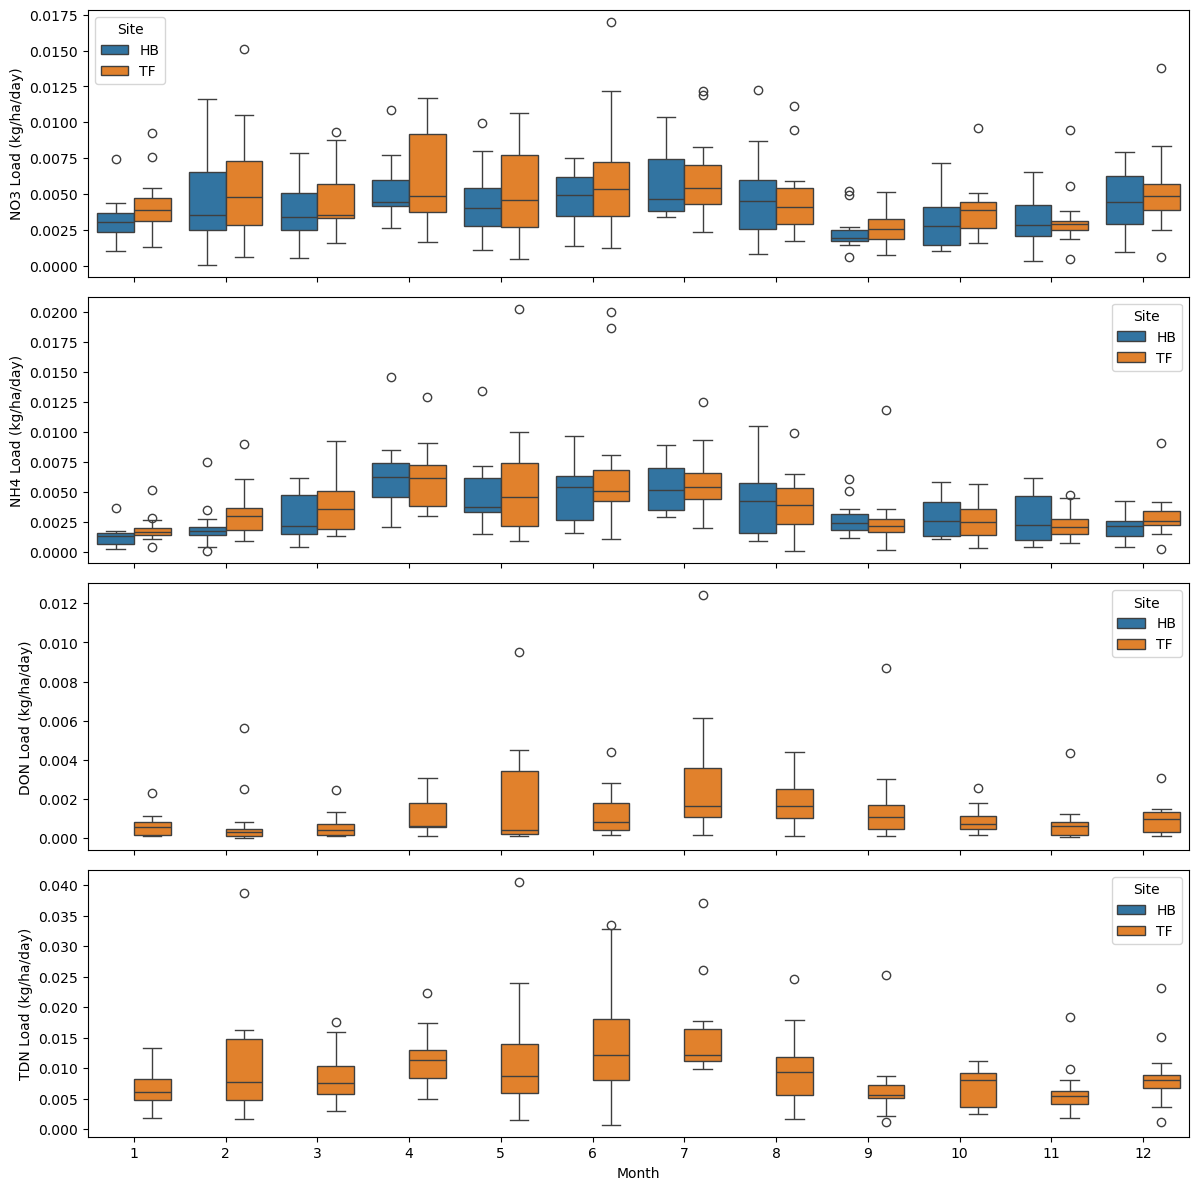

In [11]:
#%%#%%Intrannual variability of wet deposition loads
load_cols = [f"{s}_load_kg_ha_d" for s in solutes]

fig, axes = plt.subplots(len(solutes), 1, figsize=(12, 3*len(solutes)), sharex=True)

for ax, s in zip(axes, solutes):
    load_col = f"{s}_load_kg_ha_d"
    
    sns.boxplot(
        data=monthly_weighted,
        x="month",
        y=load_col,
        hue="site",
        ax=ax
    )
    
    ax.set_ylabel(f"{s} Load (kg/ha/day)")
    ax.legend(title="Site")

axes[-1].set_xlabel("Month")
plt.tight_layout()
plt.show()

**Figure 4.** Monthly loads for NH4, NO3, DON, and TDN from 2009-2021. 

Loads show greater variability than concentrations, but NH₄ and NO₃ are still generally higher during the spring and summer months. 

**Examining Interannual Variability**

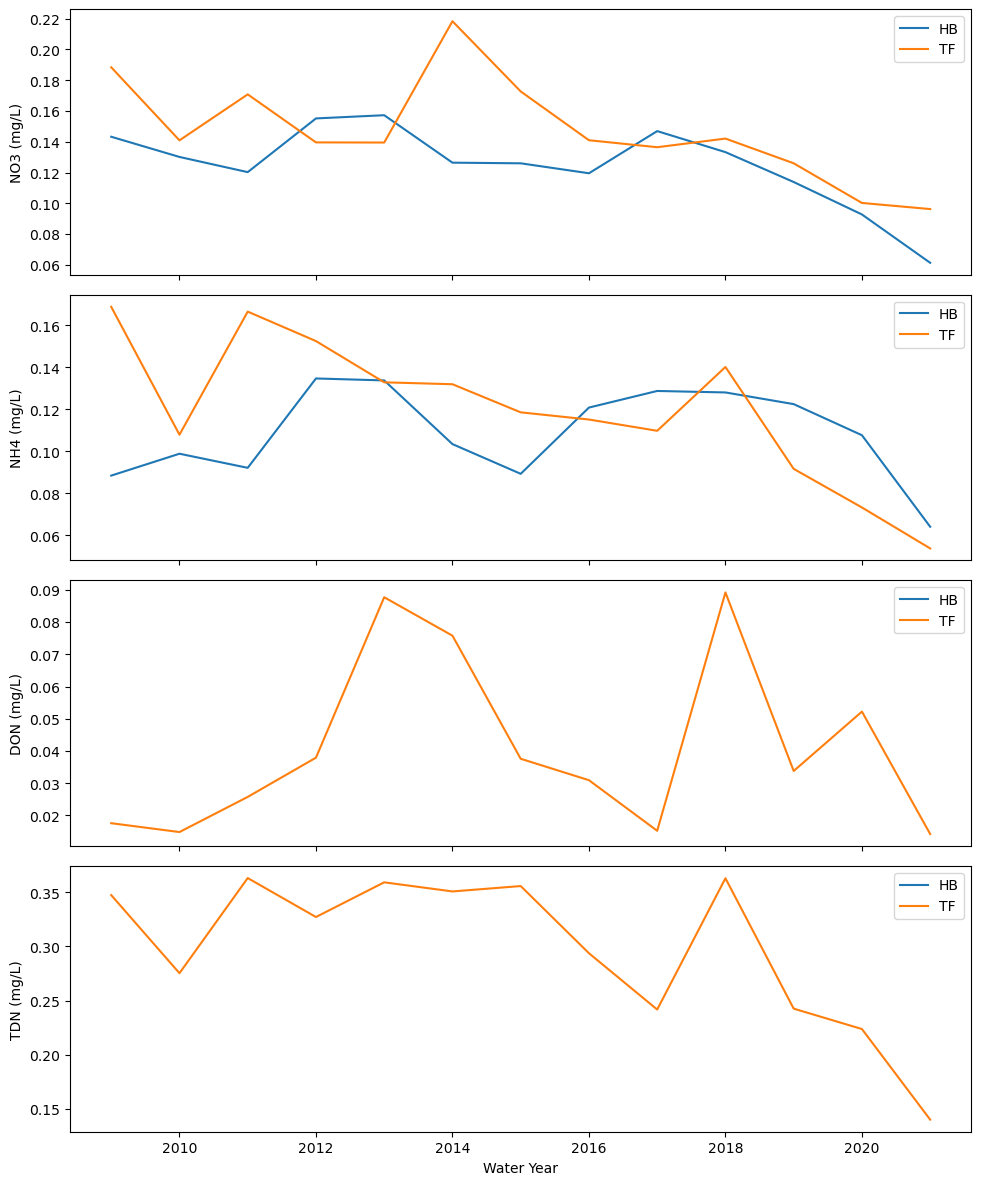

In [12]:
#%%Interannual variability line graphs
#Annual VWM Concentrations
solutes = ['NO3', 'NH4', 'DON', 'TDN']  # list of solutes
fig, axes = plt.subplots(len(solutes), 1, figsize=(10, 3*len(solutes)), sharex=True)

for ax, s in zip(axes, solutes):
    for site in annual['site'].unique():
        site_data = annual[annual['site'] == site]
        ax.plot(site_data['wateryear'], site_data[f'{s}_mgL_vwm'], label=site)
    ax.set_ylabel(f'{s} (mg/L)')
    ax.legend()

axes[-1].set_xlabel('Water Year')
plt.tight_layout()
plt.show()

**Figure 5.** Annual VWM concentrations for NH4, NO3, DON, and TDN 2009-2021 at HB and TF. 

NH4, NO3, and TDN decrease over this period of time, however, DON fluctuates. DON concentrations are low and contribute a smaller portion of TDN but could lead to increasing TDN in certain years (e.g. 2018).

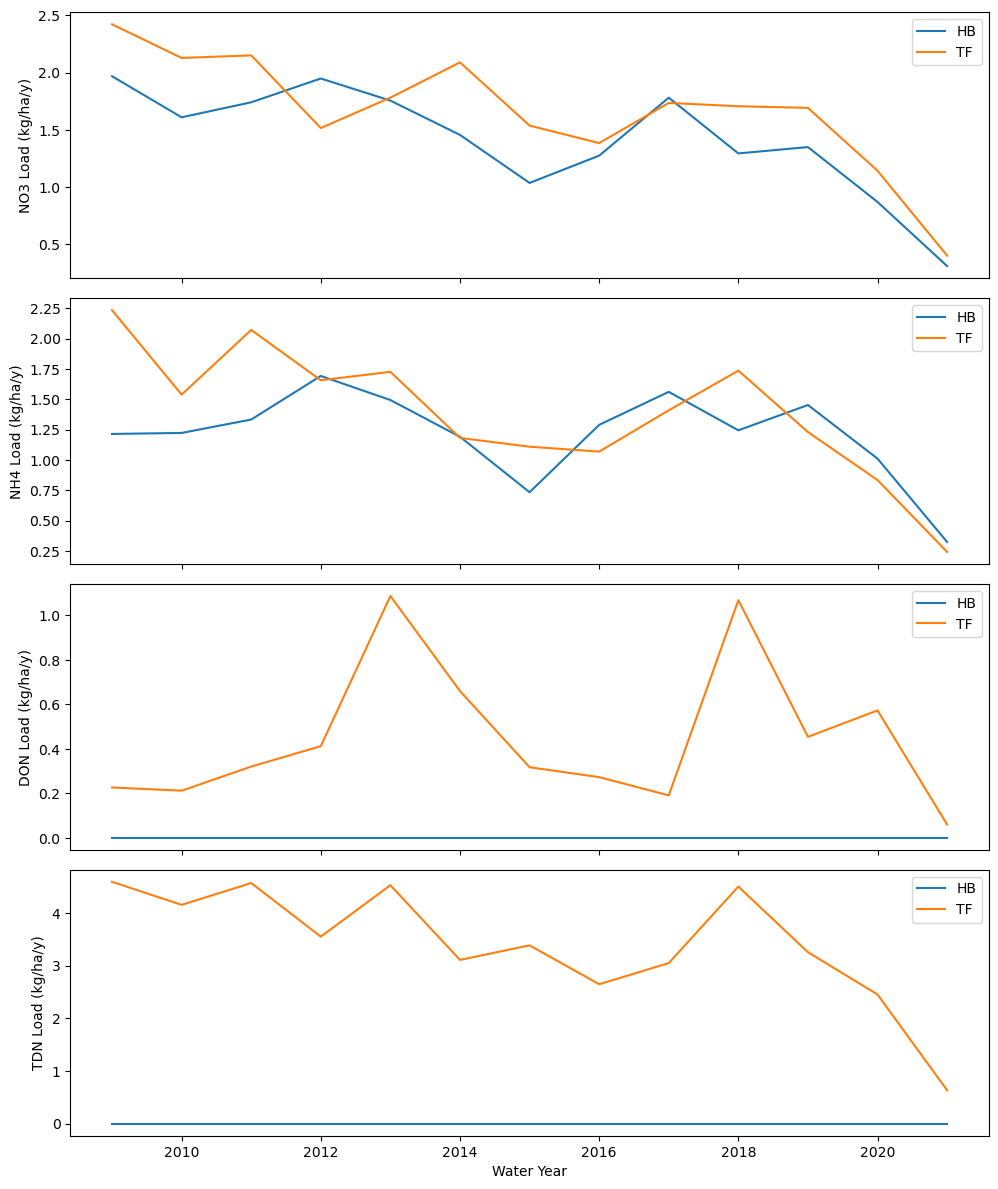

In [13]:
#Interannual varaibility for annual Loads 
solutes = ['NO3', 'NH4', 'DON', 'TDN']  # list of solutes to plot
fig, axes = plt.subplots(len(solutes), 1, figsize=(10, 3*len(solutes)), sharex=True)

for ax, s in zip(axes, solutes):
    for site in annual['site'].unique():
        site_data = annual[annual['site'] == site]
        ax.plot(site_data['wateryear'], site_data[f'{s}_annual_load_kg_ha_y'], label=site)
    ax.set_ylabel(f'{s} Load (kg/ha/y)')
    ax.legend()

axes[-1].set_xlabel('Water Year')
plt.tight_layout()
plt.show()

**Figure 6.** Annual loads for NH4, NO3, DON, and TDN 2009-2021 at HB and TF. 

## Discussion

There doesn't seem to be differences in NH4 and NO3 concentrations between two sites in NH. Both inorganic and organic solutes tend to decrease between 2009 and 2021. There does seem to be seasonal varaibilty in the type of N deposition at each site. 

Seasonal changes in precipitation type and chemistry thus drive intra-annual variation in nitrogen wet deposition. Differences in concentrations and loads of NO₃⁻, NH₄⁺, and DON are influenced not only by the amount of precipitation but also by its type (rain vs. snow), which can alter the relative abundance of nitrogen species (Murray et al. 2022). At these New Hampshire sites, NO₃⁻ and TDN concentrations generally decreased between 2009 and 2021, consistent with national trends in oxidized nitrogen deposition, while DON showed increasing or stable trends. However, NH4 also decreased over this period at both sites which is contrary to national trends(Driscoll et al, 2024). The variability in nitrogen wet deposition is primarily driven by temporal factors such as seasonality and precipitation type, rather than local spatial differences. Understanding these temporal patterns is crucial for predicting ecosystem responses to changing nitrogen.

## References
Cornell, S. E. (2011). Atmospheric nitrogen deposition: Revisiting the question of the importance of the organic component. Environmental Pollution, 159(10), 2214–2222. https://doi.org/10.1016/j.envpol.2010.11.014

Driscoll, C., Milford, J. B., Henze, D. K., & Bell, M. D. (2024). Atmospheric reduced nitrogen: Sources, transformations, effects, and management. Journal of the Air & Waste Management Association, 74(6), 362–415. https://doi.org/10.1080/10962247.2024.2342765

Du, E. (2016). Rise and fall of nitrogen deposition in the United States. Proceedings of the National Academy of Sciences, 113(26), E3594–E3595. https://doi.org/10.1073/pnas.1607543113

Galloway, J. N. (2005). The global nitrogen cycle: Past, present and future. Science in China Series C: Life Sciences, 48(2), 669–678. https://doi.org/10.1007/BF03187108

Gilliam, F. S., Burns, D. A., Driscoll, C. T., Frey, S. D., Lovett, G. M., & Watmough, S. A. (2019). Decreased atmospheric nitrogen deposition in eastern North America: Predicted responses of forest ecosystems. Environmental Pollution, 244, 560–574. https://doi.org/10.1016/j.envpol.2018.09.135

Houlton, B. Z., Boyer, E., Finzi, A., Galloway, J., Leach, A., Liptzin, D., Melillo, J., Rosenstock, T. S., Sobota, D., & 
Townsend, A. R. (2013). Intentional versus unintentional nitrogen use in the United States: Trends, efficiency and implications. Biogeochemistry, 114(1), 11–23. https://doi.org/10.1007/s10533-012-9801-5

Lassiter, M. G., Lin, J., Compton, J. E., Phelan, J., Sabo, R. D., Stoddard, J. L., McDow, S. R., & Greaver, T. L. (2023). Shifts in the composition of nitrogen deposition in the conterminous United States are discernable in stream chemistry. Science of The Total Environment, 881, 163409. https://doi.org/10.1016/j.scitotenv.2023.163409

Murray, D. S., Shattuck, M. D., McDowell, W. H., & Wymore, A. S. (2022). Nitrogen wet deposition stoichiometry: The role of organic nitrogen, seasonality, and snow. Biogeochemistry, 160(3), 301–314. https://doi.org/10.1007/s10533-022-00966-0

Murray, D. S., & Wymore, A. S. (2024). Seasonal and Climatic Drivers of Wet Deposition Organic Matter at the Continental Scale. Journal of Geophysical Research: Biogeosciences, 129(11), e2024JG008403. https://doi.org/10.1029/2024JG008403

Nanus, L., Campbell, D. H., Lehmann, C. M. B., & Mast, M. A. (2018). Spatial and temporal variation in sources of atmospheric nitrogen deposition in the Rocky Mountains using nitrogen isotopes. Atmospheric Environment, 176, 110–119. https://doi.org/10.1016/j.atmosenv.2017.12.023

Neff, J. C., Holland, E. A., Dentener, F. J., McDowell, W. H., & Russell, K. M. (2002). The origin, composition and rates of organic nitrogen deposition: A missing piece of the nitrogen cycle? Biogeochemistry, 57(1), 99–136. https://doi.org/10.1023/A:1015791622742

Ollinger, S. V., Aber, J. D., Lovett, G. M., Millham, S. E., Lathrop, R. G., & Ellis, J. M. (1993). A Spatial Model of Atmospheric Deposition for the Northeastern U.S. Ecological Applications, 3(3), 459–472. https://doi.org/10.2307/1941915

Schwede, D. B., Simpson, D., Tan, J., Fu, J. S., Dentener, F., Du, E., & deVries, W. (2018). Spatial variation of modelled total, dry and wet nitrogen deposition to forests at global scale. Environmental Pollution, 243, 1287–1301. https://doi.org/10.1016/j.envpol.2018.09.084

Wetherbee, G. A., & Mast, M. A. (2016). Annual variations in wet-deposition chemistry related to changes in climate. Climate Dynamics, 47(9), 3141–3155. https://doi.org/10.1007/s00382-016-3017-7